C:\Users\amirr\AppData\Local\Temp\ipykernel_19096\471462361.py:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,0.96])


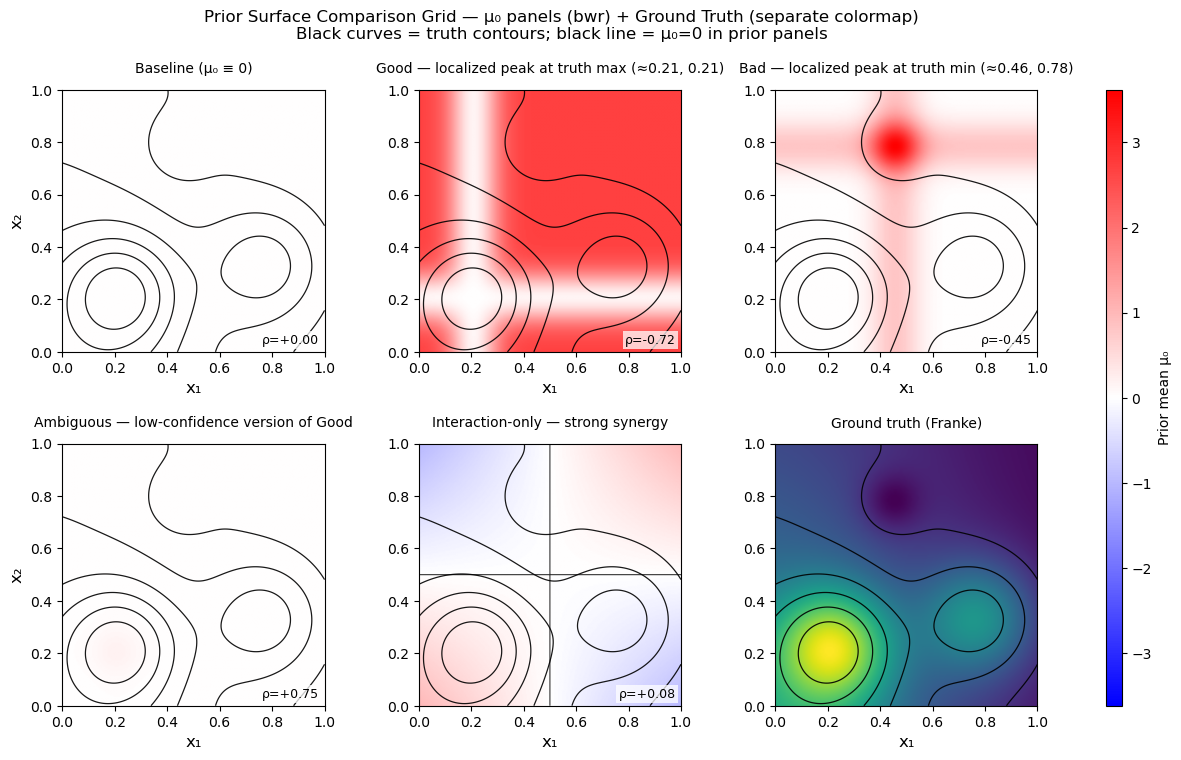

In [ ]:
# ===== Prior Surface Comparison Grid (with Truth panel & black contours) =====
# Self-contained: imports, domain, truth, text->prior mapping, panels, plot.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# ---------------- 1) Domain & Ground Truth (Franke surface) ----------------
N = 200
x = np.linspace(0, 1, N)
X1, X2 = np.meshgrid(x, x)

def franke_surface(x, y):
    t1 = 0.75 * np.exp(-((9*x-2)**2 + (9*y-2)**2)/4)
    t2 = 0.75 * np.exp(-((9*x+1)**2)/49 - (9*y+1)/10)
    t3 = 0.50 * np.exp(-((9*x-7)**2 + (9*y-3)**2)/4)
    t4 = -0.2 * np.exp(-((9*x-4)**2 + (9*y-7)**2))
    return t1 + t2 + t3 + t4

Z_true = franke_surface(X1, X2)

# ---------------- 2) Text readout -> prior mean μ0(x1,x2) -------------------
def bump_gaussian(u, center, width):
    width = max(width, 1e-3)
    return np.exp(-0.5 * ((u - center) / (width/2.355))**2)  # FWHM≈width

def shape_from_effect(effect, u, range_hint=None):
    if effect == "increase": return u
    if effect == "decrease": return 1.0 - u
    if effect == "increase-saturating": return np.sqrt(np.maximum(u, 0.0))
    if effect == "nonmonotone-peak":
        if range_hint and len(range_hint)==2:
            c = 0.5*(range_hint[0]+range_hint[1]); w = max(range_hint[1]-range_hint[0], 1e-3)
            return bump_gaussian(u, c, w)
        return 1.0 - 2.0*np.abs(u - 0.5)     # triangular peak if no hint
    if effect == "nonmonotone-valley":
        return 1.0 - shape_from_effect("nonmonotone-peak", u, range_hint)
    return np.zeros_like(u)                   # flat/unknown

def build_prior_mean(readout, X1, X2):
    """
    readout = {
      "effects": {"x1": {"effect":..., "scale":..., "confidence":..., "range_hint":[lo,hi]?},
                  "x2": {...}},
      "interactions": [{"pair":["x1","x2"], "type":"synergy|antagonism", "confidence":...}]
    }
    Returns μ0(x1,x2) with real amplitude (no per-panel normalization).
    """
    effs = readout.get("effects", {})
    e1 = effs.get("x1", {"effect":"flat","scale":0.0,"confidence":0.0})
    e2 = effs.get("x2", {"effect":"flat","scale":0.0,"confidence":0.0})
    s1 = float(e1.get("scale",0.0)) * float(e1.get("confidence",0.0))
    s2 = float(e2.get("scale",0.0)) * float(e2.get("confidence",0.0))

    S1 = shape_from_effect(e1.get("effect","flat"), X1, e1.get("range_hint"))
    S2 = shape_from_effect(e2.get("effect","flat"), X2, e2.get("range_hint"))

    Z = s1*S1 + s2*S2

    for it in (readout.get("interactions") or []):
        tp = it.get("type", "synergy"); cf = float(it.get("confidence", 0.0))
        sign = +1.0 if tp == "synergy" else -1.0
        # If both shapes are zero, fall back to a global saddle so "interaction-only" is visible.
        inter = (S1*S2) if (not np.allclose(S1,0) or not np.allclose(S2,0)) else (2*X1-1)*(2*X2-1)
        Z += sign * cf * inter

    return Z

# ---------------- 3) Alignment metric (rank-based, no SciPy) ----------------
def _spearman(a, b):
    a = np.asarray(a).ravel(); b = np.asarray(b).ravel()
    def _rank(z):
        idx = np.argsort(z, kind="mergesort")
        r = np.empty_like(idx, dtype=float); r[idx] = np.arange(len(z))
        vals, inv, cnt = np.unique(z, return_inverse=True, return_counts=True)
        sums = np.bincount(inv, r); avg = sums / cnt; return avg[inv]
    ra, rb = _rank(a), _rank(b)
    ra = (ra - ra.mean())/(ra.std()+1e-12); rb = (rb - rb.mean())/(rb.std()+1e-12)
    return float((ra*rb).mean())

# ---------------- 4) Define panels (remove Random; add Truth) ----------------
# Find truth max/min coordinates (to localize Good/Bad)
ip, jp = np.unravel_index(np.argmax(Z_true), Z_true.shape)  # (row, col)
iv, jv = np.unravel_index(np.argmin(Z_true), Z_true.shape)
x1_peak, x2_peak = x[jp], x[ip]
x1_val , x2_val  = x[jv], x[iv]

def win(center, width=0.12):
    lo = max(0.0, center - 0.5*width)
    hi = min(1.0, center + 0.5*width)
    return [lo, hi]

baseline = {"title":"Baseline (μ₀ ≡ 0)",
            "readout":{"effects":{"x1":{"effect":"flat","scale":0,"confidence":0},
                                  "x2":{"effect":"flat","scale":0,"confidence":0}},
                       "interactions":[]}}

good = {"title": f"Good — localized peak at truth max (≈{x1_peak:.2f}, {x2_peak:.2f})",
        "readout":{"effects":{
                        "x1":{"effect":"nonmonotone-peak","scale":0.25,"confidence":0.6,"range_hint":win(x1_peak,0.16)},
                        "x2":{"effect":"nonmonotone-peak","scale":0.25,"confidence":0.6,"range_hint":win(x2_peak,0.16)}},
                   "interactions":[{"pair":["x1","x2"],"type":"synergy","confidence":2.4}]}}

bad  = {"title": f"Bad — localized peak at truth min (≈{x1_val:.2f}, {x2_val:.2f})",
        "readout":{"effects":{
                        "x1":{"effect":"nonmonotone-peak","scale":0.9,"confidence":0.9,"range_hint":win(x1_val,0.16)},
                        "x2":{"effect":"nonmonotone-peak","scale":0.9,"confidence":0.9,"range_hint":win(x2_val,0.16)}},
                   "interactions":[{"pair":["x1","x2"],"type":"synergy","confidence":2.0}]}}

ambiguous = {"title":"Ambiguous — low-confidence version of Good",
             "readout":{"effects":{
                            "x1":{"effect":"nonmonotone-peak","scale":0.12,"confidence":0.18,"range_hint":win(x1_peak,0.16)},
                            "x2":{"effect":"nonmonotone-peak","scale":0.10,"confidence":0.18,"range_hint":win(x2_peak,0.16)}},
                       "interactions":[{"pair":["x1","x2"],"type":"synergy","confidence":0.15}]}}

interaction_only = {"title":"Interaction-only — strong synergy",
                    "readout":{"effects":{"x1":{"effect":"flat","scale":0,"confidence":0},
                                          "x2":{"effect":"flat","scale":0,"confidence":0}},
                               "interactions":[{"pair":["x1","x2"],"type":"synergy","confidence":1.0}]}}

truth_panel = {"kind":"truth", "title":"Ground truth (Franke)", "cmap":"viridis"}

# Compose final 2×3 grid: 5 prior panels + 1 truth panel
PANELS = [
    {"kind":"prior", **baseline},
    {"kind":"prior", **good},
    {"kind":"prior", **bad},
    {"kind":"prior", **ambiguous},
    {"kind":"prior", **interaction_only},
    truth_panel,
]

# ---------------- 5) Plot with shared prior colorbar + truth heatmap --------
def plot_prior_grid_with_truth(panels=None, save_dir=None, fname="Prior_Surface_Comparison_Grid"):
    """
    panels: list of 6 dicts:
      - prior panels: {"kind":"prior", "title":..., "readout": {...}}
      - truth panel : {"kind":"truth", "title":..., "cmap": "..."}
    """
    if panels is None:
        panels = PANELS

    rows, cols = 2, 3
    assert len(panels) == rows*cols, "Need exactly 6 panels for a 2×3 grid."

    # Precompute μ0 for prior panels
    panel_data = []
    for p in panels:
        if p.get("kind","prior") == "prior":
            Z = build_prior_mean(p["readout"], X1, X2)
        elif p.get("kind") == "truth":
            Z = None
        else:
            raise ValueError(f"Unknown panel kind: {p.get('kind')}")
        panel_data.append((p, Z))

    # Global color scale for PRIOR panels only
    prior_vals = [np.max(np.abs(Z)) for (p, Z) in panel_data if (p.get("kind","prior")=="prior")]
    prior_abs_max = max(1e-6, max(prior_vals) if prior_vals else 1e-6)
    vmin, vmax, prior_cmap = -prior_abs_max, +prior_abs_max, "bwr"

    fig = plt.figure(figsize=(14, 8), constrained_layout=False)
    gs = GridSpec(rows, cols+1, figure=fig, width_ratios=[1,1,1,0.05], wspace=0.18, hspace=0.35)

    TITLE_FS = 10       # panel title font size
    LABEL_FS = 12       # axis label font size
    TITLE_PAD = 12      # push titles a bit higher

    for i, (p, Z) in enumerate(panel_data):
        r, c = divmod(i, cols)
        ax = fig.add_subplot(gs[r, c])

        if p.get("kind","prior") == "truth":
            # Truth heatmap + its own small horizontal colorbar
            im_truth = ax.imshow(Z_true, origin="lower", extent=(0,1,0,1),
                                 cmap=p.get("cmap","viridis"), interpolation="bilinear")
            levels = np.linspace(Z_true.min(), Z_true.max(), 8)
            ax.contour(X1, X2, Z_true, levels=levels, colors="black", linewidths=0.9, alpha=0.9)
            ax.set_xlim(0,1); ax.set_ylim(0,1)
            ax.set_title(p.get("title","Ground truth"), fontsize=TITLE_FS, pad=TITLE_PAD)
            ax.set_xlabel("x₁", fontsize=LABEL_FS)
            if c == 0:
                ax.set_ylabel("x₂", fontsize=LABEL_FS, fontweight="bold")
            # cb = fig.colorbar(im_truth, ax=ax, orientation="horizontal", fraction=0.08, pad=0.08)
            # cb.set_label("Ground-truth value", fontsize=9)
        else:
            # Prior panel
            im = ax.imshow(Z, origin="lower", extent=(0,1,0,1),
                           cmap=prior_cmap, vmin=vmin, vmax=vmax, interpolation="bilinear")
            levels = np.linspace(Z_true.min(), Z_true.max(), 8)
            ax.contour(X1, X2, Z_true, levels=levels, colors="black", linewidths=0.9, alpha=0.9)
            try:
                ax.contour(X1, X2, Z, levels=[0], colors="k", linewidths=0.8, alpha=0.8)
            except Exception:
                pass
            ax.set_xlim(0,1); ax.set_ylim(0,1)
            ax.set_title(p["title"], fontsize=TITLE_FS, pad=TITLE_PAD)
            ax.set_xlabel("x₁", fontsize=LABEL_FS)
            if c == 0:
                ax.set_ylabel("x₂", fontsize=LABEL_FS)

            rho = _spearman(Z, Z_true)
            ax.text(0.98, 0.02, f"ρ={rho:+.2f}", transform=ax.transAxes,
                    ha="right", va="bottom", fontsize=9,
                    bbox=dict(facecolor="white", edgecolor="none", alpha=0.75, pad=1.5))
            ax.set_xlabel("x₁"); 
            if c == 0: ax.set_ylabel("x₂")

    # Shared colorbar for PRIOR panels (right column)
    cax = fig.add_subplot(gs[:, -1])
    sm = ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap=prior_cmap); sm.set_array([])
    cb = fig.colorbar(sm, cax=cax); cb.set_label("Prior mean μ₀", fontsize=10)

    fig.suptitle("Prior Surface Comparison Grid — μ₀ panels (bwr) + Ground Truth (separate colormap)\n"
                 "Black curves = truth contours; black line = μ₀=0 in prior panels",
                 y=0.98, fontsize=12)
    fig.tight_layout(rect=[0,0,1,0.96])

    if save_dir:
        import os
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(f"{save_dir}/{fname}.png", dpi=180, bbox_inches="tight")
        fig.savefig(f"{save_dir}/{fname}.svg", bbox_inches="tight")
    return fig

# ---------------- 6) Run (set save_dir to a folder if you want files) --------
_ = plot_prior_grid_with_truth(panels=PANELS, save_dir=None)
plt.show()
